# Mobile Game A/B Testing
---
> **목차(Context)**

* 문제 해결 전체 프로세스 정의
* Mobile Game A/B Testing
* 결과 해석 및 현업 적용


## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ version update가 유저들의 게임 경험(전체 game rounds / Retention 1, 7)에 미치는 영향이 불분명하다.
```  

> **기대효과**

```
▶ version update가 긍정적이라면, 유저들의 플레이 시간과 재방문율을 높일 수 있다.
```

> **Mobile A/B Testing**

```
▶ Mobile Game Data EDA
▶ Mobile Game A/B Testing
```

> **결과 해석 및 현업 적용**  

```
▶ 결과에 따라 업데이트 결정
```

In [ ]:
# ▶ Data read
import pandas as pd 
df = pd.read_csv('game.csv')
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Mobile Game A/B Testing

### Mobile Game Data 탐색

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
# 개별 Feature에 대한 탐색

# userid - 개별 유저에 대한 id 정보를 나타낸다. 범주형 변수
# version - 게임사에서 진행하는 버전 정보를 나타낸다. 범주형 변수
# sum_gamerounds - 유저가 특정 버전에서 진행한 총 게임 라운드를 의미한다. 연속형 변수
# retention 1, 7 - 특정 버전 설치 이후에 1, 7일 이후 접속 여부를 나타낸다. 범주형 변수

df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [ ]:
# 개별 Column 이름, 상태 공간, 일부 데이터 탐색
for col in df.columns:
    print(col, df[col].nunique(), df[col].unique()[:3])

userid 90189 [116 337 377]
version 2 ['gate_30' 'gate_40']
sum_gamerounds 942 [  3  38 165]
retention_1 2 [False  True]
retention_7 2 [False  True]


In [ ]:
# 결측치 탐색
# 모든 Column에서 결측 데이터가 없다.
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [ ]:
# retention 1, 7 데이터 변환
# True > 1
# False > 0
import numpy as np

df['retention_1'] = np.where(df['retention_1'], 1, 0)
df['retention_7'] = np.where(df['retention_7'], 1, 0)

In [ ]:
df['retention_1'].value_counts()

0    50036
1    40153
Name: retention_1, dtype: int64

In [ ]:
df['retention_7'].value_counts()

0    73408
1    16781
Name: retention_7, dtype: int64

In [ ]:
# 연속형 변수 sum_gamerounds에 대한 탐색
df_version_30 = df[df['version'] == 'gate_30']
df_version_40 = df[df['version'] == 'gate_40']

In [ ]:
# version 30에서는 일부 유저의 play rounds가 매우 큰 것이 보인다.
df_version_30['sum_gamerounds'].describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

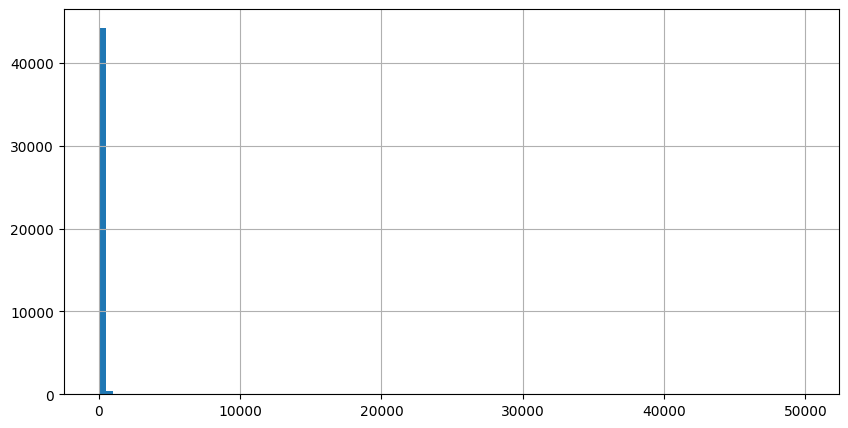

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

df_version_30['sum_gamerounds'].hist(bins=100)
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
print(np.quantile(df_version_30['sum_gamerounds'], 0.95))
print(np.quantile(df_version_30['sum_gamerounds'], 0.97))
print(np.quantile(df_version_30['sum_gamerounds'], 0.99))

222.0
301.02999999999884
493.0


In [ ]:
# version 40에서는 일부 유저의 play rounds가 매우 큰 것이 보인다.
# version 30과 마찬가지로 일부 유저가 이상치처럼 존재한다.
df_version_40['sum_gamerounds'].describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

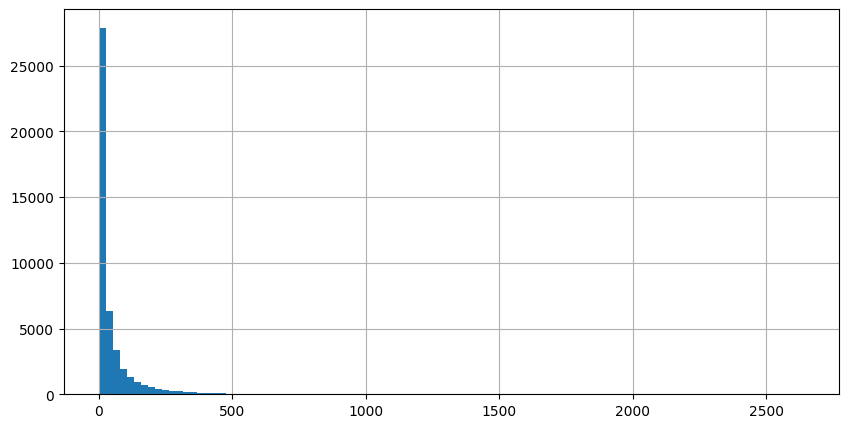

In [ ]:
df_version_40['sum_gamerounds'].hist(bins=100)
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
df[df['sum_gamerounds'] < 2].shape

(9532, 5)

In [ ]:
# version 30 / 40의 sum_gamerounds 분포를 통해 크게 다음과 같이 3가지로 구분 지을 수 있겠다.

# 1. 전체 유저

# 2. 이상치 제거 (game rounds가 일반 유저들에 비해 크게 높은 유저들을 제외)
# > 일반 유저들에 비교해 game rounds가 큰 유저들은 version이 미치는 영향을 적을 수 있다.
# > 버전을 변경하더라도 꾸준하게 진행할 것이라고 가정한다.

# 3. game 자체를 많이 진행하지 않은 유저들
# > play 경험 자체가 적은 유저들은 version이 미치는 영향을 정확하게 파악할 수 없다.
# > 일반적인 경향을 파악하기 어렵다고 생각하고 제외한다.

In [ ]:
# version update의 긍정적 영향을 검토하기 위해 A/B Testing을 진행한다.
# version > 게임에 미치는 영향(sum_gamerounds / retention 1, 7)을 확인한다.

### **Session 1. 전체 데이터에 대한 A/B Testing**  
---

#### 1.1 대조군, 실험군 선정

In [ ]:
df_version_30 = df[df['version'] == 'gate_30'] # 대조군. 과거 버전
df_version_40 = df[df['version'] == 'gate_40'] # 실험군. 적용할 버전

In [ ]:
# 실험군과 대조군의 샘플 수에 차이가 있지만, 크지 않기 때문에 무시하고 넘어간다.
print(df_version_30.shape, df_version_40.shape)

(44700, 5) (45489, 5)


#### 1.2 version이 sum_gamerounds에 미치는 영향

In [ ]:
# 서로 다른 2개의 집단에서 sum_gamerounds(연속형 변수)에 미치는 영향을 파악하기 위해 "독립 표본 t검정"을 진행한다.
# 독립 표본 t 검정을 진행하기 위해서는 1. 독립 / 2. 정규성 / 3. 등분산을 먼저 검토해야 한다.

In [ ]:
df.groupby(['version'])['sum_gamerounds'].mean()

version
gate_30    52.456264
gate_40    51.298776
Name: sum_gamerounds, dtype: float64

In [ ]:
# 독립 표본 t 검정을 진행하기 전에 boxplot을 통해서 먼저 확인한다.

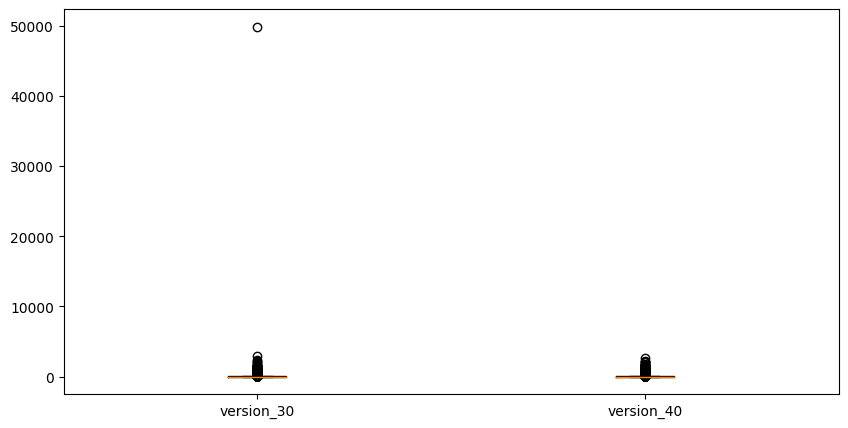

In [ ]:
# 전체 데이터를 대상으로 박스 플롯을 그려보면, 이상치로 인해서 비교할 수 없다.
# 그래서 일부 데이터만을 비교해서 version의 차이를 비교해보려 한다.
plt.boxplot([df_version_30['sum_gamerounds'], df_version_40['sum_gamerounds']])
plt.xticks([1, 2], ['version_30', 'version_40'])
plt.gcf().set_size_inches(10, 5)
plt.show()

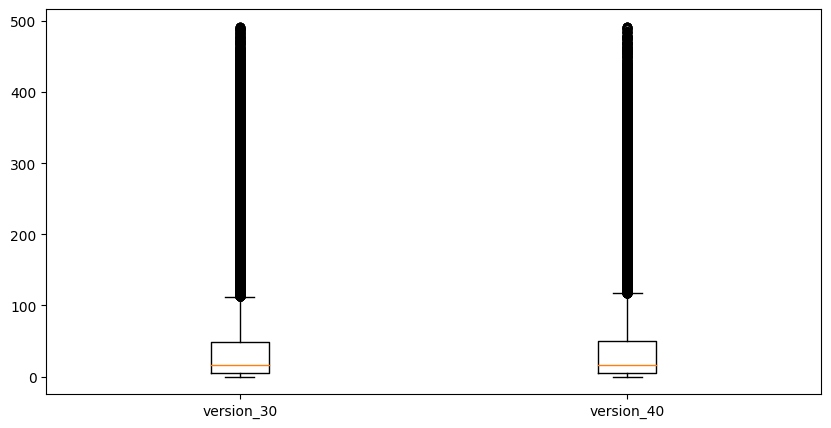

In [ ]:
# 1%의 데이터를 제외하고, version에 따른 데이터를 비교하면 분포 및 평균에서 큰 차이가 없다.
df_version_30_99th = np.quantile(df_version_30['sum_gamerounds'], 0.99)
df_version_40_99th = np.quantile(df_version_40['sum_gamerounds'], 0.99)

plt.boxplot(
    [df_version_30[df_version_30['sum_gamerounds'] < df_version_30_99th]['sum_gamerounds'],
     df_version_40[df_version_40['sum_gamerounds'] < df_version_40_99th]['sum_gamerounds']])
plt.xticks([1, 2], ['version_30', 'version_40'])
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
# 1. 독립
# > version이 서로에게 영향을 주지 않는다고 가정한다.

In [ ]:
# 2. 정규성
# pvalue를 통해서 2개의 집단 모두 정규 분포를 띄고 있다고 판단한다.

from scipy.stats import *
print(kstest(df_version_30['sum_gamerounds'], 'norm'))
print(kstest(df_version_40['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.8724176532867202, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


In [ ]:
# 3. 등분산
pvalue = levene(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'])[1]

if pvalue < 0.05:
    equal_var = False
else:
    equal_var = True

print(pvalue, equal_var)

0.46694516772623273 True


In [ ]:
# 독립 표본 t 검정
# H0. 귀무 가설, 영가설
# 두 집단(version30, version40)의 표본 평균은 동일하다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미치지 않는다.

# H1. 대립 가설.
# 두 집단(version30, version40)의 표본 평균은 같지 않다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미친다.

print(ttest_ind(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'],
    equal_var=equal_var))

Ttest_indResult(statistic=0.8910426211362967, pvalue=0.37290868247405207)


In [ ]:
# pvalue를 통해서 version(30 / 40)이 유저들의 sum_gamerounds에 영향을 미치지 못 한다고 판단한다.

#### 1.3 version이 retention에 미치는 영향

In [ ]:
# 수치 차이가 큰 것 같지는 않지만, 유의미한 차이인지 우연에 의한 것인지 확인한다.
df.groupby(['version'])[['retention_1', 'retention_7']].mean()

# 설치 이후 하루가 지났을 때는 0.1%p의 차이가 있다.
# 설치 이후 일주일이 지났을 때는 1%p의 차이가 있다.
# 평균의 비교를 통해서는 크게 차이가 나지 않는다.

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


In [ ]:
# version(범주형 변수)
# retention 1, 7(범주형 변수)
# version, retention 모두 범주형 변수이기에 Chi2 검정을 진행한다.

##### 1.3.1 version이 retention 1에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_1)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_1)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df['version'], 
    df['retention_1'])

obs

retention_1,0,1
version,,
gate_30,24666,20034
gate_40,25370,20119


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.07550476210309086


In [ ]:
# 앞서 설정한 0.05보다 크다.
# > 귀무 가설이 참이다.
# 이를 통해 version이 설치 후 하루 지나서 접속 여부에 영향을 주지 못 한다는 결론을 내릴 수 있다.

##### 1.3.2 version이 retention 7에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_7)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_7)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df['version'], 
    df['retention_7'])

obs

retention_7,0,1
version,,
gate_30,36198,8502
gate_40,37210,8279


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.0016005742679058301


In [ ]:
# 앞서 설정한 0.05보다 작다.
# 이를 통해 version이 설치 후 일주일 지나서 접속 여부에 영향을 준다.
# 하지만, 오히려 새롭게 적용되는 version 40에서 떨어지는 결과가 보인다.
# 그래서 새로운 업데이트가 오히려 부정적인 영향을 내린다고 판단할 수 있다.

#### 1.4 결과



In [ ]:
# 대상 - 전체 유저
# 1. version / sum_gamerounds
# version이 user들의 게임 rounds에 영향을 미치지 못 한다.

# 2. version / retention 1
# version은 retention 1에 영향을 미치지 못 한다.
# 적용 이후에 유저들의 접속률에 영향을 주지 못 한다.

# 3. version / retention 7
# version은 retention 7에 영향을 미친다.
# 하지만, 오히려 부정적인 영향을 미치기 때문에 전체 유저들을 대상으로 update 진행은 바람직하지 못 하다.

### **Session 2. 이상치 제거 데이터에 대한 A/B Testing**  
---

In [ ]:
# 전체 유저들은 일반적인 평가를 하기 어렵다.
# 그래서 이번 Session에서는 특별히 sum_gamerounds가 높은 유저들을 제외하고, version의 영향을 체크한다.
# 특별히 sum_gamerounds가 높은 유저들은 version의 영향이 적을거라 가정하고 진행한다.

# 이상치의 기준은 sum_gamerounds의 상위 1%로 설정했다.
outlier = np.quantile(df['sum_gamerounds'], 0.99)
df_cp = df.copy()
df_without_outlier = df_cp[df_cp['sum_gamerounds'] < outlier]

#### 2.1 대조군, 실험군 선정

In [ ]:
df_version_30 = df_without_outlier[df_without_outlier['version'] == 'gate_30'] # 대조군. 과거 버전
df_version_40 = df_without_outlier[df_without_outlier['version'] == 'gate_40'] # 실험군. 적용할 버전

In [ ]:
# 실험군과 대조군의 샘플 수에 차이가 있지만, 크지 않기 때문에 무시하고 넘어간다.
print(df_version_30.shape, df_version_40.shape)

(44249, 5) (45034, 5)


#### 2.2 version이 sum_gamerounds에 미치는 영향

In [ ]:
# 검정을 진행하기 전에 version에 따른 mean을 비교한다.
df_without_outlier.groupby(['version'])['sum_gamerounds'].mean()

# version의 sum_gamerounds 평균을 비교하면, 큰 차이는 보이지 않는다.
# 하지만, 이 차이가 우연인지 유의미한 차이인지 검토해야 한다.

version
gate_30    44.611833
gate_40    44.366501
Name: sum_gamerounds, dtype: float64

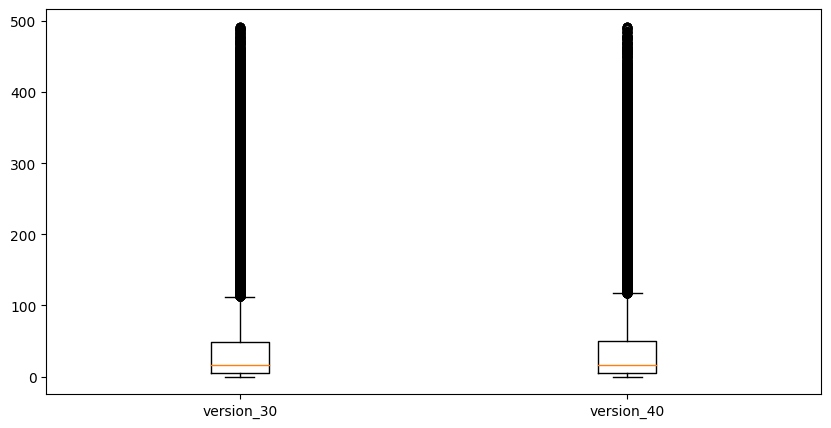

In [ ]:
# box plot을 통해 비교 결과 둘의 분포 및 평균의 큰 차이는 보이지 않는다.
plt.boxplot([df_version_30['sum_gamerounds'], df_version_40['sum_gamerounds']])
plt.xticks([1, 2], ['version_30', 'version_40'])
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
# 앞선 경우와 동일하게 독립 / 정규 / 등분산 검정을 진행한다.

In [ ]:
# 1. 독립
# > version이 서로에게 영향을 주지 않는다고 가정한다.

In [ ]:
# 2. 정규성
# pvalue를 통해서 2개의 집단 모두 정규 분포를 띄고 있다고 판단한다.

from scipy.stats import *
print(kstest(df_version_30['sum_gamerounds'], 'norm'))
print(kstest(df_version_40['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.8713491697309548, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8696422826718856, pvalue=0.0, statistic_location=2, statistic_sign=-1)


In [ ]:
# 3. 등분산
pvalue = levene(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'])[1]

if pvalue < 0.05:
    equal_var = False
else:
    equal_var = True

print(pvalue, equal_var)

0.9484769714207988 True


In [ ]:
# 독립 표본 t 검정
# H0. 귀무 가설, 영가설
# 두 집단(version30, version40)의 표본 평균은 동일하다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미치지 않는다.

# H1. 대립 가설.
# 두 집단(version30, version40)의 표본 평균은 같지 않다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미친다.

print(ttest_ind(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'],
    equal_var=equal_var))

Ttest_indResult(statistic=0.5111372064397172, pvalue=0.6092562485495854)


In [ ]:
# pvalue를 통해서 이상치를 제거한 데이터에서도 version이 sum_gamerounds에 미치는 영향이 없다고 판단할 수 있다.

#### 2.3 version이 retention에 미치는 영향

In [ ]:
# 평균 비교를 통해 version이 미치는 영향을 조사한다.
df_without_outlier.groupby(['version'])[['retention_1', 'retention_7']].mean()

# 설치 이후 하루가 지났을 때는 1%p의 차이가 있다.
# 설치 이후 일주일이 지났을 때는 1%p의 차이가 있다.
# 크게 차이는 보이지 않는 것처럼 보인다. 하지만, 이 차이가 우연인지 유의미한 차이인지 확인한다.

,retention_1,retention_7
version,,
gate_30,0.442857,0.182445
gate_40,0.436870,0.174135


##### 2.3.1 version이 retention 1에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_1)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_1)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df_without_outlier['version'], 
    df_without_outlier['retention_1'])

obs

retention_1,0,1
version,,
gate_30,24653,19596
gate_40,25360,19674


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.0725938768474489


In [ ]:
# 앞서 설정한 0.05보다 크다.
# 이를 통해 version이 설치 후 하루 지나서 접속 여부에 영향을 주지 못 한다는 결론을 내릴 수 있다.

##### 2.3.2 version이 retention 7에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_7)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_7)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df_without_outlier['version'], 
    df_without_outlier['retention_7'])

obs

retention_7,0,1
version,,
gate_30,36176,8073
gate_40,37192,7842


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.0012167914022157224


In [ ]:
# 앞서 설정한 0.05보다 작다.
# 이를 통해 version이 설치 후 일주일 지나서 접속 여부에 영향을 준다.
# 하지만, 오히려 새롭게 적용되는 version 40에서 떨어지는 결과가 보인다.
# 그래서 새로운 업데이트가 오히려 부정적인 영향을 내린다고 판단할 수 있다.

#### 2.4 결과



In [ ]:
# 대상 - 이상치 제거 유저 # sum_gamerounds 상위 1%를 제외하고 분석

# 1. version / sum_gamerounds
# version이 user들의 게임 rounds에 영향을 미치지 못 한다.
# 오히려 game rounds를 낮추는 부정적 결과를 가져온다.

# 2. version / retention 1
# version은 retention 1에 영향을 미치지 못 한다.
# 적용 이후에 유저들의 접속률에 영향을 주지 못 한다.

# 3. version / retention 7
# version은 retention 7에 영향을 미친다.
# 하지만, 오히려 부정적인 영향을 미치기 때문에 전체 유저들을 대상으로 update 진행은 바람직하지 못 하다.

### **Session 3. 게임을 실행한 일반 유저에 대한 A/B Testing**  
---

In [ ]:
# version이 일반 유저들에게 미치는 영향을 파악하기 위해서는
# 1. 플레이 경험이 적은 유저들은 제외해야 한다.
# 2. 특이하게 플레이 경험이 많은 유저들도 제외해야 한다.

# 그래서 이번 Session에서는 특별히 sum_gamerounds가 높은 유저들과 플레이 경험이 적은 유저들을 제외하고, version의 영향을 체크한다.
# 이 2가지 경우는 일반적인 version update의 제대로 된 효과를 파악하기 어렵다고 생각했다.

# 이상치의 기준은 sum_gamerounds의 상위 1%로 설정했다.
# 플레이 경험이 적은 유저들은 sum_gamerounds를 5 이하들의 유저로 설정했다.

df_cp = df.copy()

outlier = np.quantile(df_cp['sum_gamerounds'], 0.99)
first_cond = df_cp['sum_gamerounds'] < outlier

k = 5
second_cond = df_cp['sum_gamerounds'] > k

df_normal = df_cp[first_cond & second_cond]
print(df.shape, df_normal.shape)

(90189, 5) (64566, 5)


#### 3.1 대조군, 실험군 선정

In [ ]:
df_version_30 = df_normal[df_normal['version'] == 'gate_30'] # 대조군. 과거 버전
df_version_40 = df_normal[df_normal['version'] == 'gate_40'] # 실험군. 적용할 버전

In [ ]:
# 실험군과 대조군의 샘플 수에 차이가 있지만, 크지 않기 때문에 무시하고 넘어간다.
print(df_version_30.shape, df_version_40.shape)

(32193, 5) (32373, 5)


#### 3.2 version이 sum_gamerounds에 미치는 영향

In [ ]:
# 검정을 진행하기 전에 version에 따른 mean을 비교한다.
# version의 sum_gamerounds 평균을 비교하면, 큰 차이는 보이지 않는다.
# 하지만, 이 차이가 우연인지 유의미한 차이인지 검토해야 한다.
df_normal.groupby(['version'])['sum_gamerounds'].mean()

version
gate_30    60.468207
gate_40    60.830847
Name: sum_gamerounds, dtype: float64

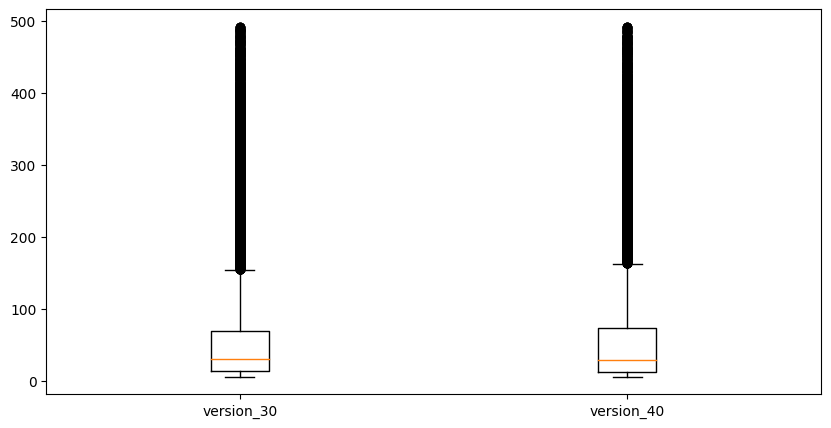

In [ ]:
# box plot을 통해 비교 결과 둘의 분포 및 평균의 큰 차이는 보이지 않는다.
plt.boxplot([df_version_30['sum_gamerounds'], df_version_40['sum_gamerounds']])
plt.xticks([1, 2], ['version_30', 'version_40'])
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
# 앞선 경우와 동일하게 독립 / 정규 / 등분산 검정을 진행한다.

In [ ]:
# 1. 독립
# > version이 서로에게 영향을 주지 않는다고 가정한다.

In [ ]:
# 2. 정규성
# pvalue를 통해서 2개의 집단 모두 정규 분포를 띄고 있다고 판단한다.

from scipy.stats import *
print(kstest(df_version_30['sum_gamerounds'], 'norm'))
print(kstest(df_version_40['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.9999999990134123, pvalue=0.0, statistic_location=6, statistic_sign=-1)
KstestResult(statistic=0.9999999990134123, pvalue=0.0, statistic_location=6, statistic_sign=-1)


In [ ]:
# 3. 등분산
pvalue = levene(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'])[1]

if pvalue < 0.05:
    equal_var = False
else:
    equal_var = True

print(pvalue, equal_var)

0.3552594294014306 True


In [ ]:
# 독립 표본 t 검정
# H0. 귀무 가설, 영가설
# 두 집단(version30, version40)의 표본 평균은 동일하다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미치지 않는다.

# H1. 대립 가설.
# 두 집단(version30, version40)의 표본 평균은 같지 않다.
# > version(독립 변수)은 sum_gamerounds(종속 변수)에 영향을 미친다.

print(ttest_ind(
    df_version_30['sum_gamerounds'], 
    df_version_40['sum_gamerounds'],
    equal_var=equal_var))

Ttest_indResult(statistic=-0.5867585228331695, pvalue=0.5573679484845161)


In [ ]:
# pvalue를 통해서 일반 유저 데이터에서도 version이 sum_gamerounds에 미치는 영향이 없다고 판단할 수 있다.

#### 3.3 version이 retention에 미치는 영향

In [ ]:
# 평균 비교를 통해 version이 미치는 영향을 조사한다.
df_normal.groupby(['version'])[['retention_1', 'retention_7']].mean()

# 설치 이후 하루가 지났을 때는 0.5%p의 차이가 있다.
# 설치 이후 일주일이 지났을 때는 1%p의 차이가 있다.

,retention_1,retention_7
version,,
gate_30,0.584444,0.246203
gate_40,0.579773,0.237111


##### 3.3.1 version이 retention 1에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_1)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_1)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df_normal['version'], 
    df_normal['retention_1'])

obs

retention_1,0,1
version,,
gate_30,13378,18815
gate_40,13604,18769


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.23203731636371877


In [ ]:
# 앞서 설정한 0.05보다 크다.
# 이를 통해 version이 설치 후 하루 지나서 접속 여부에 영향을 주지 못 한다는 결론을 내릴 수 있다.

##### 3.3.2 version이 retention 7에 미치는 영향

In [ ]:
# H0 - 귀무 가설
# 두 범주형 변수(version, retention_7)은 독립이다.

# H1 - 대립 가설
# 두 범주형 변수(version, retention_7)은 종속이다.

In [ ]:
obs = pd.crosstab(
    df_normal['version'], 
    df_normal['retention_7'])

obs

retention_7,0,1
version,,
gate_30,24267,7926
gate_40,24697,7676


In [ ]:
chi2, pvalue, dof, expected = chi2_contingency(obs)
print(pvalue)

0.007166095160559729


In [ ]:
# 앞서 설정한 0.05보다 작다.
# 이를 통해 version이 설치 후 일주일 지나서 접속 여부에 영향을 준다.
# 하지만, 오히려 새롭게 적용되는 version 40에서 떨어지는 결과가 보인다.
# 그래서 새로운 업데이트가 오히려 부정적인 영향을 내린다고 판단할 수 있다.

#### 3.4 결과

In [ ]:
# 대상 - 일반 유저

# 1. version / sum_gamerounds
# version이 user들의 게임 rounds에 영향을 미치지 못 한다.

# 2. version / retention 1
# version은 retention 1에 영향을 미치지 못 한다.
# 적용 이후에 유저들의 접속률에 영향을 주지 못 한다.

# 3. version / retention 7
# version은 retention 7에 영향을 미친다.
# 하지만, 오히려 부정적인 영향을 미치기 때문에 전체 유저들을 대상으로 update 진행은 바람직하지 못 하다.


## **결과 해석 및 현업 적용**
---
게임을 이용하는 유저들을 크게 3가지(전체 / 이상치 제거 / 일반)로 나눠서 version이 미치는 영향을 살펴봤다.

> **1. version / sum_gamerounds와의 관계**

```
3가지 모든 경우에 대해서 version이 sum_gamerounds에 미치는 영향이 없다고 판단한다.
```  

> **2. version / retention 1와의 관계**

```
3가지 모든 경우에 대해서 version이 sum_gamerounds에 미치는 영향이 없다고 판단한다.
```

> **3. version / retention 7와의 관계**

```
3가지 모든 경우에 대해서 version이 retention 7에 미치는 영향이 있다고 판단한다. 
하지만, 부정적 영향이 미치는 것으로 판단했다.
```

> **현업 적용**  

```
최종 결론으로 현재의 update(version 40)은 진행하면 안 된다.
유저의 플레이 경험에 영향을 주지 못 하며, 오히려 일주일이 지나면 접속 자체를 낮춘다.
그래서 현재의 버전을 유지하거나 다른 방향으로의 업데이트를 진행해야 한다.
```
